In [7]:
# import package
import torch
import torch.nn as nn
import torchvision.models as model
import torchsummary
from torchsummary import summary
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# import cv2
import scipy.io as matlabio
import scipy.signal as sig
import codecs
import struct
import re
import pandas as pd
import myLib
import os, glob
from torch.utils.data import random_split
import importlib
import glob
import myLib
from tqdm import tqdm
import custom_module
import pathlib
import random
import shutil
from scipy import optimize as op
import os
import time
import my_loss_func as lf
importlib.reload(myLib)
importlib.reload(custom_module)

<module 'custom_module' from 'd:\\DaMing\\code\\python\\python\\custom_module.py'>

In [ ]:
model = custom_module.test_net(kernel=15)
data_path = glob.glob(r'D:\daming\train_demod' +
r'\validation\data\*.npy')
label_path = glob.glob(r'D:\daming\train_demod' +
r'\validation\label\*.npy')
model.load_state_dict(torch.load(r'C:\Users\Buslab\Desktop\Experiment data\DaMing\contusion\dis' +
r'placement_estimation\model_2layer_kernel15_linearscale_0.7powloss_lr0.0001_bs4_1.pt'))
norm_mean = -5
norm_std = 0.5
i=159
d=200
d2=485
data_path = sorted(data_path, key=lambda x: int(x[38:-4]))
label_path = sorted(label_path, key=lambda x: int(x[39:-4]))
data = np.load(data_path[i]).astype(np.float32).reshape((1, 1, 1000, -1))
label = np.load(label_path[i]).astype(np.float32)
data = torch.tensor(data)
output = model(data).detach().numpy().reshape(1000, -1)
temp2 = np.abs(output - (label-norm_mean)/norm_std).mean()

plt.figure(figsize=(12,4))
plt.plot(output[d, :])
plt.plot((label[d, :]-norm_mean)/norm_std, 'r')
# plt.axis([-10, 1000, 0, 25])
plt.show()

plt.figure(figsize=(12,4))
plt.plot(output[d2, :])
plt.plot((label[d2, :]-norm_mean)/norm_std, 'r')
# plt.axis([-10, 1000, 0, 25])
plt.show()


In [ ]:
# FCN

kernel_height = 7
model=custom_module.test_net(kernel=kernel_height)
model.eval()
data_path = glob.glob(r'D:\DaMing\sw_data\demod_adjust\validation' +
r'\data\*.npy')
label_path = glob.glob(r'D:\DaMing\sw_data\demod_adjust\validation' +
r'\label\*.npy')
model.load_state_dict(torch.load(r'D:\DaMing\sw_data\model_output' +
r'\FCN_2layer_kernel7_linearscale_lr0.0001_bs4_2.pt'))
model = model.cuda()

norm_mean = 0
norm_std = 1
i=np.random.randint(0, high=len(data_path))
d=np.random.randint(0, high=1000)
print(f'i={i}, d={d}')
# i=17
# d=968

if(1):
    file_index = re.search("validation", data_path[0]).start()
    data_path = sorted(data_path, key=lambda x: int(x[file_index+16:-4]))
    print(data_path[i])
    data = torch.tensor(np.load(data_path[i]).astype(np.float32))[None, None].cuda()
    label_path = sorted(label_path, key=lambda x: int(x[file_index+17:-4]))
    label = np.load(label_path[i]).astype(np.float32)

    output = model(data)

    output = output.detach().cpu().numpy()
    output = output[0, 0, d, :]
    label = label[d, :]

    temp1 = np.power(output - (label-norm_mean)/norm_std, 2).mean()

    print(np.corrcoef(output, label))
    print(np.mean((output-label)**2))
    plt.figure(figsize=(12,4))
    plt.plot(output)
    plt.plot(label, 'r')
    # plt.plot((label[d, :]-norm_mean)/norm_std, 'r')
    # plt.axis([-10, 1000, 0, 25])
    plt.show()
    
myLib.show_training_result(output, label, -0.6, 0.65, 0.103, 0.008, 0.2)


In [ ]:
# flownetC flownetS pwcnet evaluation

model=custom_module.FlowNetC_hollow_3(is_corr_fun_calc = True)
model.eval()
data_path = glob.glob(r'D:\DaMing\sw_data\demod_adjust\validation' +
r'\data\*.npy')
label_path = glob.glob(r'D:\DaMing\sw_data\demod_adjust\validation' +
r'\label\*.npy')
model.load_state_dict(torch.load(r'D:\DaMing\sw_data\model_output' +
r'\flownetC_512_2layer_kernel7_linearscale_0.7powloss_lr0.0001_bs4_13:flownetC_slim_3.pt'))
model = model.cuda()

norm_mean = 0
norm_std = 1
i=np.random.randint(0, high=len(data_path))
d=np.random.randint(0, high=1000)
print(f'i={i}, d={d}')
# i=11
# d=68

if(1):
    file_index = re.search("validation", data_path[0]).start()
    data_path = sorted(data_path, key=lambda x: int(x[file_index+16:-4]))
    print(data_path[i])
    data = torch.tensor(np.load(data_path[i]).astype(np.float32)).cuda()
    label_path = sorted(label_path, key=lambda x: int(x[file_index+17:-4]))
    label = np.load(label_path[i]).astype(np.float32)

    is_corr_fun_calc = True
    data = data[None].permute((0, 2, 1))
    data = nn.functional.interpolate(data, size=512, mode='linear', align_corners=False).permute(0, 2, 1)[None]
    local_bz = data.size(0)
    time_steps = 920
    input_feature_dim = 512
    if is_corr_fun_calc:
        temp = data.reshape((-1, input_feature_dim, time_steps))
        xcorr_func = torch.zeros(local_bz, time_steps, input_feature_dim)
        # 需更改model的in_feature_dim
        for bz in range(0, local_bz):
            temp1 = temp[bz:bz+1, :, :].permute((0, 2, 1))
            temp2 = temp[bz:bz+1, :, 0:1].repeat((1, 1, time_steps)).permute((2, 0, 1))
            xcorr_func[bz, :, :] = nn.functional.conv1d(temp1, temp2, groups=time_steps, padding='same')[0, :, :]
            xcorr_func[bz, :, :] = (xcorr_func[bz, :, :]-xcorr_func[bz, :, :].min())/(xcorr_func[bz, :, :].max()-xcorr_func[bz, :, :].min())
        xcorr_func = xcorr_func[None].permute((1, 0, 3, 2)).cuda()
        # data = torch.cat([data, xcorr_func], dim=1)
    
    output = model(data)
    output = nn.functional.interpolate(output, size=1000, mode='linear', align_corners=False)

    output = torch.cat((torch.tensor([0]), output[:, 0, d].cpu().detach()), dim=0)
    output = output.numpy()
    label = label[d, :]

    cc = np.corrcoef(output, label)[0, 1]
    mse = np.mean((output-label)**2).item()

    # print(np.corrcoef(output, label))
    # print(np.mean((output-label)**2))
    # plt.figure(figsize=(12,4))
    # plt.plot(output)
    # plt.plot(label, 'r')
    # plt.plot((label[d, :]-norm_mean)/norm_std, 'r')
    # plt.axis([-10, 1000, 0, 25])
    # plt.show()
    
    myLib.show_training_result(output, label, -0.8, 0.8, np.round(cc, 2), np.round(mse, 2), 0.2)

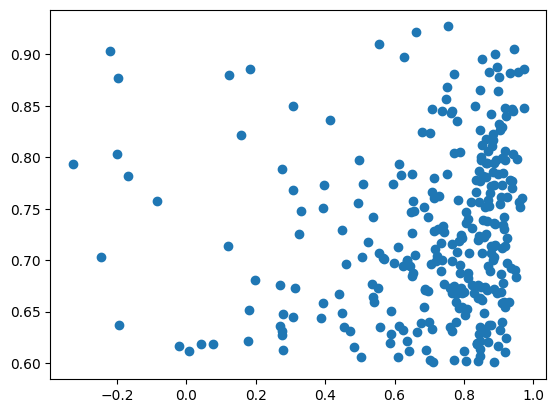

In [32]:
data_list = np.zeros((len(val_label), 3))
for i in range(0, len(val_label)):
    # if int(data_path[i][:-4])%10 == 0 or int(data_path[i][:-4])%10 ==1:
    data_list[i, 0] = int(data_path[i][:-4])
    data_list[i, 1] = np.mean(xl[i])
    temp = val_label[i].reshape((1000, 5, 184))
    label_xl = np.zeros(1000)
    for j in range(0, 1000):
        label_xl[j] = (np.sum(np.corrcoef(temp[j, :, :]))-5)/20
    data_list[i, 2] = np.mean(label_xl)

plt.scatter(1-data_list[:, 1], data_list[:, 2])

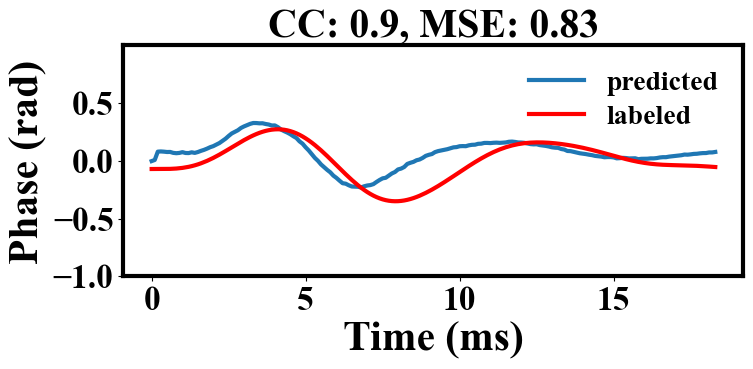

In [123]:
importlib.reload(myLib)
importlib.reload(custom_module)
idx =155
dp = 500
temp = np.load(rf'D:\DaMing\sw_data\all_data\label\1748.npy')[1000:2000].reshape((1000, 5, 184)).mean(axis=1)
# temp = val_label[idx].reshape((1000, 5, 184)).mean(axis=1)
mse = np.mean((val_output[idx]-temp)**2).item()
# myLib.show_training_result(val_output[idx][dp, :], val_label[idx][dp, :], -1, 1, np.round(1-data_list[idx, 1], 2), np.round(data_list[idx, 2], 2), 0.5)
myLib.show_training_result(val_output[idx][dp, :], temp[dp, :], -1, 1, np.round(1-data_list[idx, 1], 2), np.round(data_list[idx, 2], 2), 0.5)

# idx = 53
# dp = 500
# temp = val_label[idx].reshape((1000, 5, 184)).mean(axis=1)
# mse = np.mean((val_output[idx]-temp)**2).item()
# # myLib.show_training_result(val_output[idx][dp, :], val_label[idx][dp, 184*3:], -1, 1, np.round(1-data_list[idx, 1], 2), np.round(data_list[idx, 2], 2), 0.5)
# myLib.show_training_result(val_output[idx][dp, :], temp[dp, :], -1, 1, np.round(1-data_list[idx, 1], 2), np.round(data_list[idx, 2], 2), 0.5)

In [14]:
print('test',
      'test2')

test test2
